In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasettif-v5/DatasetTIF-V5/DatasetTIF-V5/validation/SeaLake/SeaLake_562.tif
/kaggle/input/datasettif-v5/DatasetTIF-V5/DatasetTIF-V5/validation/SeaLake/SeaLake_1452.tif
/kaggle/input/datasettif-v5/DatasetTIF-V5/DatasetTIF-V5/validation/SeaLake/SeaLake_2876.tif
/kaggle/input/datasettif-v5/DatasetTIF-V5/DatasetTIF-V5/validation/SeaLake/SeaLake_594.tif
/kaggle/input/datasettif-v5/DatasetTIF-V5/DatasetTIF-V5/validation/SeaLake/SeaLake_2348.tif
/kaggle/input/datasettif-v5/DatasetTIF-V5/DatasetTIF-V5/validation/SeaLake/SeaLake_551.tif
/kaggle/input/datasettif-v5/DatasetTIF-V5/DatasetTIF-V5/validation/SeaLake/SeaLake_1949.tif
/kaggle/input/datasettif-v5/DatasetTIF-V5/DatasetTIF-V5/validation/SeaLake/SeaLake_448.tif
/kaggle/input/datasettif-v5/DatasetTIF-V5/DatasetTIF-V5/validation/SeaLake/SeaLake_100.tif
/kaggle/input/datasettif-v5/DatasetTIF-V5/DatasetTIF-V5/validation/SeaLake/SeaLake_2821.tif
/kaggle/input/datasettif-v5/DatasetTIF-V5/DatasetTIF-V5/validation/SeaLake/SeaLake_26

2025-06-13 13:54:24.848919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749822865.078126      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749822865.143248      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading SeaLake: 100%|██████████| 1400/1400 [00:09<00:00, 141.86it/s]


Balanced Data - Agricultural: 4200
Balanced Data - Non-Agricultural: 4200


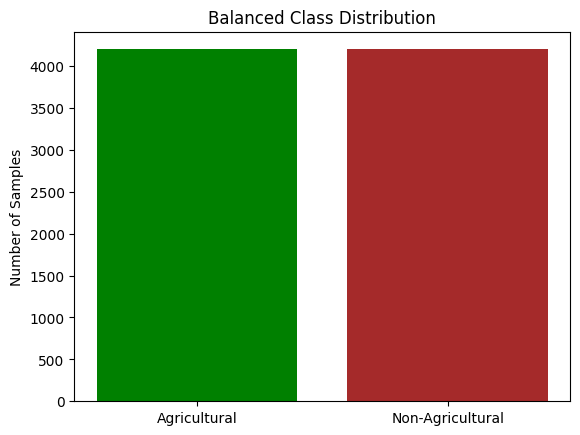

2025-06-13 13:56:27.194886: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - accuracy: 0.7510 - loss: 0.4984 - val_accuracy: 0.8661 - val_loss: 0.3395
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 39s 107ms/step - accuracy: 0.8618 - loss: 0.3277 - val_accuracy: 0.8923 - val_loss: 0.2670
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.8586 - loss: 0.3105 - val_accuracy: 0.8964 - val_loss: 0.2411
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.8788 - loss: 0.2758 - val_accuracy: 0.8988 - val_loss: 0.2340
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - accuracy: 0.8834 - loss: 0.2796 - val_accuracy: 0.8863 - val_loss: 0.2670
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.8846 - loss: 0.2692 - val_accuracy: 0.9000 - val_loss: 0.2268
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.8730 - loss: 0.2920 - val_accuracy: 0.9030 - val_loss: 0.2329
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 24s 112ms/step - accuracy: 0.8959 - loss: 0

In [2]:
import os
import numpy as np
import tifffile as tiff
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers

# Define dataset path
dataset_path = '/kaggle/input/datasettif-v5/DatasetTIF-V5/DatasetTIF-V5/training'

# Define class names
agricultural_classes = ['AnnualCrop', 'Pasture', 'PermanentCrop']
non_agricultural_classes = ['Forest', 'Highway', 'Industrial', 'Residential', 'River', 'SeaLake', 'HerbaceousVegetation']

# Load data
X, y = [], []

for class_name in sorted(os.listdir(dataset_path)):
    class_dir = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_dir):
        continue

    label = 0 if class_name in agricultural_classes else 1

    for filename in tqdm(os.listdir(class_dir), desc=f'Loading {class_name}'):
        if filename.endswith('.tif'):
            img_path = os.path.join(class_dir, filename)
            try:
                img = tiff.imread(img_path)
                if img.shape[0] == 13:  # Convert (13, H, W) to (H, W, 13)
                    img = np.moveaxis(img, 0, -1)
                if img.shape[-1] != 13:
                    continue
                img = img[:64, :64, :]  # Crop
                img = img.astype(np.float32) / 65535.0  # Normalize
                X.append(img)
                y.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

X = np.array(X)
y = np.array(y)

# Split into classes
X_agri = X[y == 0]
X_non_agri = X[y == 1]

# Undersample majority class to match minority class
X_non_agri_down = resample(X_non_agri,
                           replace=False,
                           n_samples=len(X_agri),
                           random_state=42)

y_agri = np.zeros(len(X_agri))
y_non_agri_down = np.ones(len(X_non_agri_down))

# Combine and shuffle
X_balanced = np.concatenate([X_agri, X_non_agri_down])
y_balanced = np.concatenate([y_agri, y_non_agri_down])

# Shuffle
shuffle_idx = np.random.permutation(len(X_balanced))
X_balanced = X_balanced[shuffle_idx]
y_balanced = y_balanced[shuffle_idx]

# Print new class distribution
print(f"Balanced Data - Agricultural: {np.sum(y_balanced == 0)}")
print(f"Balanced Data - Non-Agricultural: {np.sum(y_balanced == 1)}")

# Plot distribution
plt.bar(['Agricultural', 'Non-Agricultural'],
        [np.sum(y_balanced == 0), np.sum(y_balanced == 1)],
        color=['green', 'brown'])
plt.title('Balanced Class Distribution')
plt.ylabel('Number of Samples')
plt.show()

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# Build model
model = models.Sequential([
    layers.Input(shape=(64, 64, 13)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")


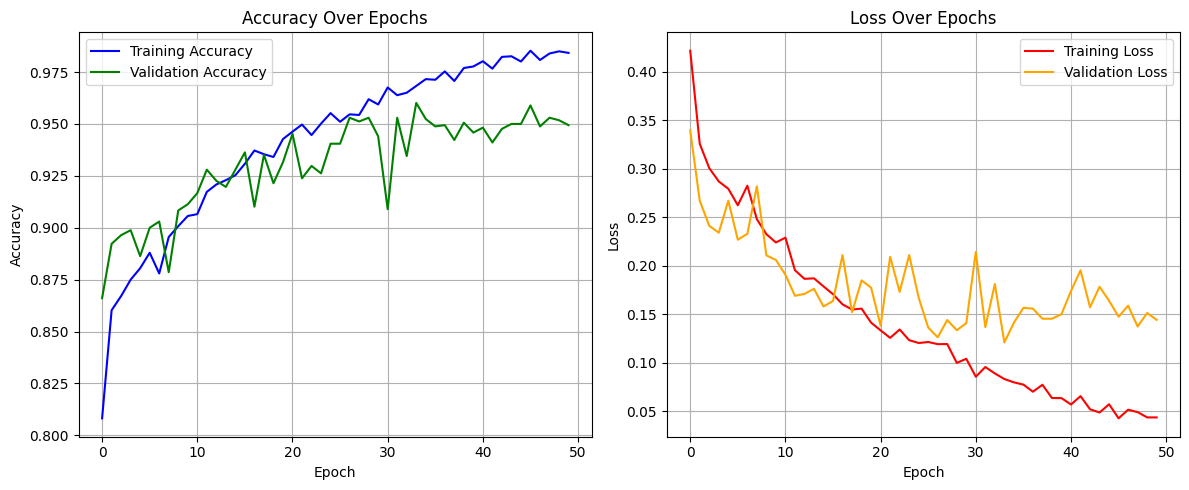

In [3]:
import matplotlib.pyplot as plt

# رسم منحنى الدقة
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# رسم منحنى الخسارة
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


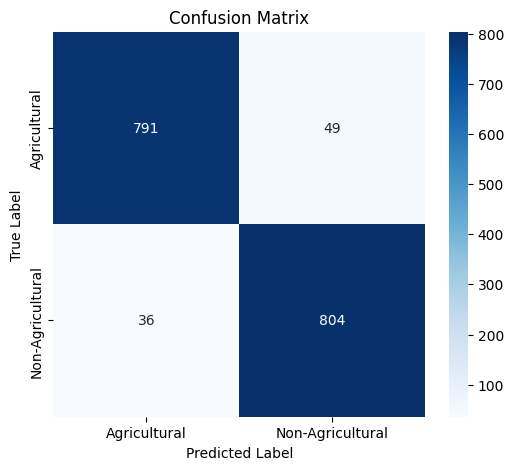

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# تنبؤات النموذج على بيانات التحقق
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# مصفوفة الالتباس
cm = confusion_matrix(y_val, y_pred)
labels = ['Agricultural', 'Non-Agricultural']

# عرض مصفوفة الالتباس
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
